# Sentiment Analysis Comparison

This IPython Notebook shows you the comparison between the latest Sentiment Analysis algorithm added to the marketplace (Social Sentiment Analysis), and the previously popular used algorithm.

Table of Content:
1. [Comparing the old and new Sentiment Analysis Algorithm](#1.-Comparing-the-old-and-new-Sentiment-Analysis-Algorithm)
  1. [Preprocessing the data](#A.-Preprocessing-the-data)
  2. [Running benchmarks](#B.-Running-benchmarks)
  3. [Algorithm Running Time Comparison](#C.-Algorithm-Running-Time-Comparison)
  4. [Algorithm Accuracy and F1 Score Comparison](#D.-Algorithm-Accuracy-and-F1-Score-Comparison)


# 1. Comparing the old and new Sentiment Analysis Algorithm

Here we will compare the old `/nlp/SentimentAnalysis` algorithm against the new `/nlp/SocialSentimentAnalysis` algorithm.

The old algorithm is based on top of [Standford's CoreNLP library](http://stanfordnlp.github.io/CoreNLP/).

The new algorithm uses the library from SocialAI Georgia Tech called [VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf).

In [1]:
import Algorithmia
from AlgoBench.benchmark import Benchmark
import csv
import operator
import pprint
import random


pp = pprint.PrettyPrinter(indent=2)

API_KEY = 'YOUR_API_KEY'
# Create a client
client = Algorithmia.client(API_KEY)

dataset = 'data/Apple-Twitter-Sentiment-DFE.csv'

## A. Preprocessing the data
The original dataset consists a total of ~4500 tweets. We remove all unlabelled tweets, and
we also remove all the tweets that don't have a confidence value of 100%. That leaves us with about ~1800 tweets.

In [2]:
# Loading the data
def load_data():
    rVal = []
    with open(dataset, 'rb') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            # Remove top CSV line
            if row[11] != 'tweet' and row[5] != 'sentiment':
                # Remove unlabelled data
                if row[5] != 'not_relevant':
                    # Remove tweets which don't have a confidence value of 1.0
                    if float(row[6]) == 1.0:
                        item = {'data': row[11], 'label': int(row[5])}
                        rVal.append(item)
    return rVal

apple_data = load_data()

# Show random tweet examples
print 'Random example tweet: '
pp.pprint(random.choice(apple_data))

Random example tweet: 
{ 'data': 'JMP raises Apple price target from $130 to $150, reasons why here: http://t.co/XOTExD9Y4o  #JMP #AAPL #Stocks #WallStreet',
  'label': 3}


## B. Running benchmarks

We run the benchmarks using the `AlgoBench` library which can be found [here](https://github.com/algorithmiaio/algorithmia-bench).

In [3]:
%%capture
# Supress the AlgoBench status output

# Benchmark for old algo
old_algo = 'nlp/SentimentAnalysis'

settings = {'apiKey':API_KEY, 'numBenchRuns':1, 'maxNumConnections':20, 'inputLabelList': apple_data, 'algoSingle': old_algo}

def old_sa_mapping_func(res):
    label = res['label']
    # result varies between 0-4
    prediction = res['response']['result']

    if prediction == 0 or prediction == 1:
        corresponding_prediction = 1
    elif prediction == 2:
        corresponding_prediction = 3
    elif prediction == 3 or prediction == 4:
        corresponding_prediction = 5

    return {'result': corresponding_prediction, 'label': label}

# Run benchmark and calculate stats

old_sa_b = Benchmark(settings)
old_sa_b.run()
old_sa_b.calcStats(old_sa_mapping_func)

In [4]:
%%capture
# Supress the AlgoBench status output

# Benchmark for new algo
new_algo = 'nlp/SocialSentimentAnalysis'

settings = {'apiKey':API_KEY, 'numBenchRuns':1, 'maxNumConnections':20, 'inputLabelList': apple_data, 'algoSingle': new_algo}

def new_sa_mapping_func(res):
    label = res['label']
    result = res['response']['result'][0]
    result.pop("sentence", None)
    result.pop("compound", None)

    prediction = max(result.iteritems(), key=operator.itemgetter(1))[0]

    if prediction == "neutral":
        corresponding_prediction = 3
    elif prediction == "positive":
        corresponding_prediction = 5
    elif prediction == "negative":
        corresponding_prediction = 1

    return {'result': corresponding_prediction, 'label': label}

# Run benchmark
new_sa_b = Benchmark(settings)
new_sa_b.run()

# Calculate stats for benchmark
new_sa_b.calcStats(new_sa_mapping_func)

## C. Algorithm Running Time Comparison

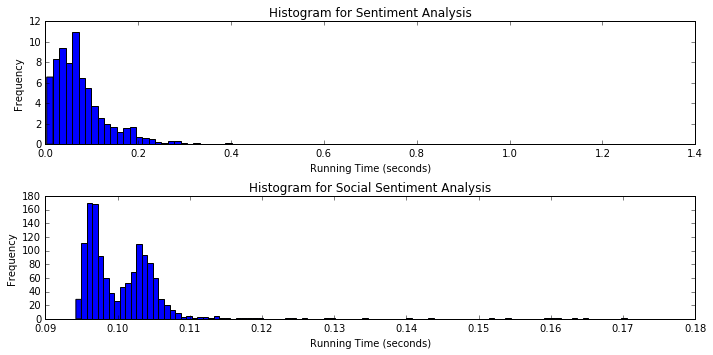

In [5]:
# Average running time for Social Sentiment API Calls
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

new_sa_data = map(lambda x: x['response']['metadata']['duration'], new_sa_b.results)
old_sa_data = map(lambda x: x['response']['metadata']['duration'], old_sa_b.results)

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.hist(old_sa_data, normed=True, bins=100, color='b')
plt.title('Histogram for Sentiment Analysis')
plt.xlabel('Running Time (seconds)');
plt.ylabel('Frequency');

plt.subplot(212)
plt.hist(new_sa_data, normed=True, bins=100, color='b')
plt.title('Histogram for Social Sentiment Analysis')
plt.xlabel('Running Time (seconds)');
plt.ylabel('Frequency');
plt.tight_layout()

In [6]:
print 'Average running time for nlp/SentimentAnalysis: ' + str(old_sa_b.average['nlp/SentimentAnalysis']) + ' ± ' + str(old_sa_b.uncertainty['nlp/SentimentAnalysis'])
print 'Average running time for nlp/SocialSentimentAnalysis: ' + str(new_sa_b.average['nlp/SocialSentimentAnalysis']) + ' ± ' + str(new_sa_b.uncertainty['nlp/SocialSentimentAnalysis'])

Average running time for nlp/SentimentAnalysis: 0.078005658 ± 0.686785052
Average running time for nlp/SocialSentimentAnalysis: 0.1005919 ± 0.03813467


## D. Algorithm Accuracy and F1 Score Comparison

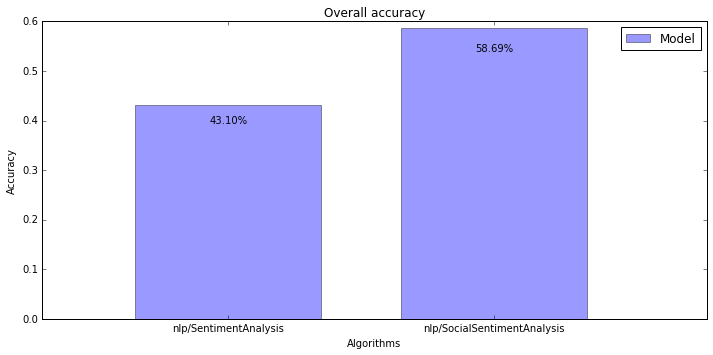

In [7]:
# Comparing overall accuracy rates
n_groups = 2
means = (old_sa_b.stats['accuracy']['overall'], new_sa_b.stats['accuracy']['overall'])
index = np.arange(n_groups)
bar_width = 0.7
opacity = 0.4

plt.figure(figsize=(10,5))

rects1 = plt.bar(index + 0.35, means, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Model')

plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Overall accuracy')
plt.xticks(index + bar_width, ('nlp/SentimentAnalysis', 'nlp/SocialSentimentAnalysis'))
plt.legend()

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., .93*height,
                str(height*100)[0:5] + '%',
                horizontalalignment='center',
                verticalalignment='center')

autolabel(rects1)

plt.tight_layout()

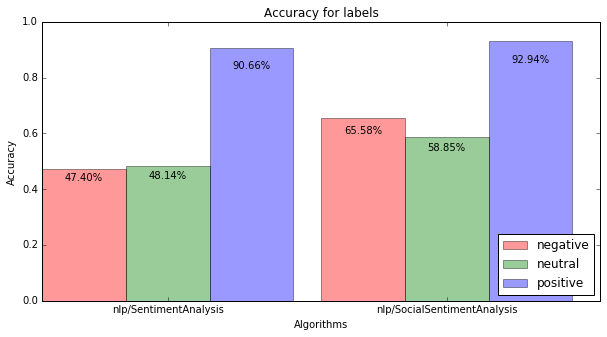

In [8]:
# Accuracy for each label
n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.4

plt.figure(figsize=(10,5))

means = {}

for label in old_sa_b.stats['accuracy']['labels']:
    means[label] = (old_sa_b.stats['accuracy']['labels'][label], new_sa_b.stats['accuracy']['labels'][label])

    
i = 0
bars = []
getColor = {1:'r', 3:'g', 5:'b'}
getLabel = {1:'negative', 3:'neutral', 5:'positive'}
for l in means:
    bars.append(plt.bar(index + i*bar_width, means[l], bar_width,
                     alpha=opacity,
                     color=getColor[l],
                     label=getLabel[l]))
    i += 1

plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy for labels')
plt.xticks(index + bar_width*1.5, ('nlp/SentimentAnalysis', 'nlp/SocialSentimentAnalysis'))
plt.legend(loc=4)

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., .93*height,
                str(height*100)[0:5] + '%',
                horizontalalignment='center',
                verticalalignment='center')
        
for bar in bars:
    autolabel(bar)

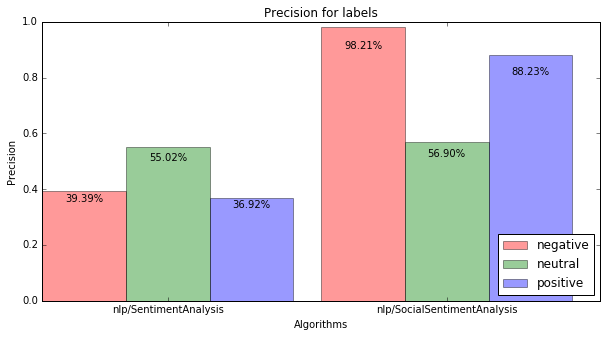

In [9]:
# Precision for each label
n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.4

plt.figure(figsize=(10,5))

means = {}

for label in old_sa_b.stats['precision']['labels']:
    means[label] = (old_sa_b.stats['precision']['labels'][label], new_sa_b.stats['precision']['labels'][label])

    
i = 0
bars = []
getColor = {1:'r', 3:'g', 5:'b'}
getLabel = {1:'negative', 3:'neutral', 5:'positive'}
for l in means:
    bars.append(plt.bar(index + i*bar_width, means[l], bar_width,
                     alpha=opacity,
                     color=getColor[l],
                     label=getLabel[l]))
    i += 1

plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.title('Precision for labels')
plt.xticks(index + bar_width*1.5, ('nlp/SentimentAnalysis', 'nlp/SocialSentimentAnalysis'))
plt.legend(loc=4)
        
for bar in bars:
    autolabel(bar)

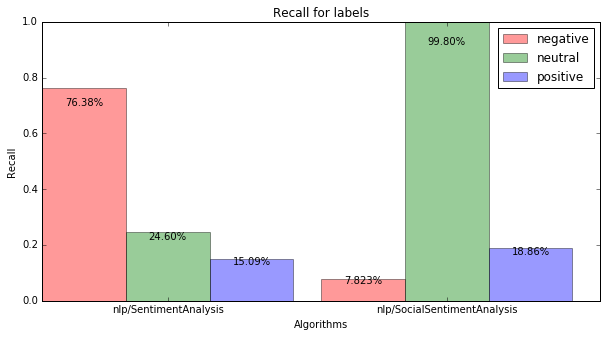

In [10]:
# Recall for each label
n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.4

plt.figure(figsize=(10,5))

means = {}

for label in old_sa_b.stats['recall']['labels']:
    means[label] = (old_sa_b.stats['recall']['labels'][label], new_sa_b.stats['recall']['labels'][label])

    
i = 0
bars = []
getColor = {1:'r', 3:'g', 5:'b'}
getLabel = {1:'negative', 3:'neutral', 5:'positive'}
for l in means:
    bars.append(plt.bar(index + i*bar_width, means[l], bar_width,
                     alpha=opacity,
                     color=getColor[l],
                     label=getLabel[l]))
    i += 1

plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.title('Recall for labels')
plt.xticks(index + bar_width*1.5, ('nlp/SentimentAnalysis', 'nlp/SocialSentimentAnalysis'))
plt.legend(loc=1)
        
for bar in bars:
    autolabel(bar)

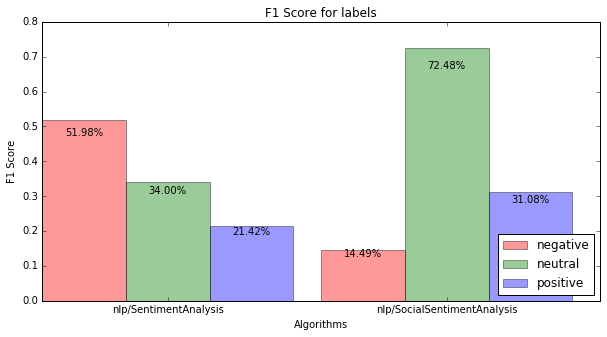

In [11]:
# F1 Score for labels
n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.4

plt.figure(figsize=(10,5))

means = {}

for label in old_sa_b.stats['fScore']['labels']:
    means[label] = (old_sa_b.stats['fScore']['labels'][label], new_sa_b.stats['fScore']['labels'][label])

    
i = 0
bars = []
getColor = {1:'r', 3:'g', 5:'b'}
getLabel = {1:'negative', 3:'neutral', 5:'positive'}
for l in means:
    bars.append(plt.bar(index + i*bar_width, means[l], bar_width,
                     alpha=opacity,
                     color=getColor[l],
                     label=getLabel[l]))
    i += 1

plt.xlabel('Algorithms')
plt.ylabel('F1 Score')
plt.title('F1 Score for labels')
plt.xticks(index + bar_width*1.5, ('nlp/SentimentAnalysis', 'nlp/SocialSentimentAnalysis'))
plt.legend(loc=4)

for bar in bars:
    autolabel(bar)